In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time

In [7]:
class voronoi:
    
    def __init__(self, data, data_name = ""):
        self.data = np.array(data)
        self.data_name = data_name
        self.cells = []
    
    def plot_points(self):
        fig, ax = plt.subplots()
        ax.set_title(self.data_name)
        ax.scatter(self.data[:, 0], self.data[:, 1])
        plt.show()
    
    # Finds which cell is the point located
    def find_cell(self, point):
        dist = float("inf")
        for i, cell in enumerate(self.cells):
            aux = np.sqrt((point[0]-cell[0][0])**2+(point[1]-cell[0][1])**2)
            if aux < dist:
                dist = aux
                pos = i
        return pos
    
    # Returns the cell that belongs to edge which is different than origin_cell 
    def find_cell_by_edge(self, edge_ref, origin_cell):
        precision = 0.7
        for i, cell in enumerate(self.cells):
            for j, edge in enumerate(cell[1]):
                if i != origin_cell:
                    if abs(edge[0][0] - edge_ref[0][0]) <= precision and abs(edge[0][1] - edge_ref[0][1]) <= precision:
                        if abs(edge[1][0] - edge_ref[1][0]) <= precision and abs(edge[1][1] - edge_ref[1][1]) <= precision:
                            output = i
                            
                    if abs(edge[1][0] - edge_ref[0][0]) <= precision and abs(edge[1][1] - edge_ref[0][1]) <= precision: 
                        if abs(edge[0][0] - edge_ref[1][0]) <= precision and abs(edge[0][1] - edge_ref[1][1]) <= precision:
                            output = i
        return output

    
    # Remakes the cell when edge is added
    def remake_cell(self, visited_cell, edge_added, point_added):
        drop = []
        
        for i, edge in enumerate(self.cells[visited_cell][1]):
            
            A = edge[0]
            B = edge[1]
            C = edge_added[0]
            D_0 = round(A[0]*B[1] + A[1]*C[0] + B[0]*C[1] - C[0]*B[1] - A[0]*C[1] - A[1]*B[0], 4)
            C = edge_added[1]
            D_1 = round(A[0]*B[1] + A[1]*C[0] + B[0]*C[1] - C[0]*B[1] - A[0]*C[1] - A[1]*B[0], 4)

            # Checking if one of the points from the new edge is colinear to the existing edge

            if max(abs(D_0), abs(D_1)) >= 2000000: precision = 1.5
            if max(abs(D_0), abs(D_1)) < 2000000 and max(abs(D_0), abs(D_1)) > 50000: precision = 0.8
            if max(abs(D_0), abs(D_1)) <= 50000 and max(abs(D_0), abs(D_1)) > 1000: precision = 0.5
            if max(abs(D_0), abs(D_1)) <= 1000: precision = 0.01
            
            if abs(D_0) <= precision or abs(D_1) <= precision: 
                if abs(D_0) <= precision: p = edge_added[0]
                else: p = edge_added[1]
                
                dist_1 = np.sqrt((point_added[0] - A[0])**2+(point_added[1] - A[1])**2)
                dist_2 = np.sqrt((self.cells[visited_cell][0][0] - A[0])**2+(self.cells[visited_cell][0][1] - A[1])**2) 
                
                if dist_1 < dist_2:
                    self.cells[visited_cell][1][i][0] = [p[0], p[1], 1][:]
                else:
                    self.cells[visited_cell][1][i][1] = [p[0], p[1], 1][:]
                
                
            if abs(D_0) > precision and abs(D_1) > precision: 
                dist_1 = np.sqrt((point_added[0] - A[0])**2+(point_added[1] - A[1])**2)
                dist_2 = np.sqrt((self.cells[visited_cell][0][0] - A[0])**2+(self.cells[visited_cell][0][1] - A[1])**2)
                
                if dist_1 < dist_2:
                    drop.append(edge)
            
        self.cells[visited_cell][1].append(edge_added[:])
        
        for element in drop:
            self.cells[visited_cell][1].remove(element)
        
    # Returns an edge in the mean distance between p and the cell's centre. 
    # Also returns the neighbour cells which need to be updates
    def make_edge(self, cell, p):
        C = self.cells[cell][0]
        M = [round((C[0] + p[0])/2, 4), round((C[1] + p[1])/2, 4)]
        V_1 = [C[0] - M[0], C[1] - M[1]]
        if V_1[1] == 0:
            V_2 = [0, 1]
        else:
            V_2 = [1, -V_1[0]/V_1[1]]
        output = []
        NEIGHBOURS = []

        for edge in self.cells[cell][1]:
            A = edge[0]
            B = edge[1]
            
            if A[0] == B[0]: 
                A[0] = A[0] + 0.1
                B[0] = B[0] - 0.1
            
            if A[1] == B[1]: 
                A[1] = A[1] + 0.1
                B[1] = B[1] - 0.1
            
            V_3 = [B[0] - A[0], B[1] - A[1]]
            D = round((-V_3[0]*V_2[1] + V_3[1]*V_2[0]), 4)
                
            if abs(D) > 0.1: # If D == 0, than the new edge does not cross edge
                D_t = (M[1] - A[1])*V_3[0] - (M[0] - A[0])*V_3[1]
                t = D_t/D
                INTERSECT = [round(M[0] + t*V_2[0], 4), round(M[1] + t*V_2[1], 4), 1]
                IS_VALID = False
                
                # Double checking if the intersection is valid by checking if the intersection if in between the edge limits
                
                if A[2] == 1 and B[2] == 1:
                    if INTERSECT[0] < max(A[0], B[0]) and INTERSECT[0] > min(A[0], B[0]):
                        IS_VALID = True                        
                
                if A[2] == 0 and B[2] == 1:
                    if A[0] > B[0] and INTERSECT[0] > B[0]:                        
                        IS_VALID = True
                    if A[0] < B[0] and INTERSECT[0] < B[0]:                        
                        IS_VALID = True

                    
                if A[2] == 1 and B[2] == 0:
                    if A[0] > B[0] and INTERSECT[0] < A[0]:
                        IS_VALID = True
                    if A[0] < B[0] and INTERSECT[0] > A[0]:
                        IS_VALID = True 
                    
                if A[2] == 0 and B[2] == 0:
                    IS_VALID = True

            
                if IS_VALID:
                    T = t
                    output.append(INTERSECT)
                    NEIGHBOURS.append(self.find_cell_by_edge(edge, cell))    
                    
        # In case len(output == 1), there is only one intersection. Thus, we need to create a half line
        if len(output) == 1:
            
            if self.find_cell(M) == cell: # If M is inside the cell, we just need to extend it (-10*V_2)                
                inf_point = [round(M[0] - 10*T*V_2[0], 4), round(M[1] - 10*T*V_2[1], 4), 0]
                i = 2
                while np.sqrt((self.cells[cell][0][0] - inf_point[0])**2 + (self.cells[cell][0][1] -inf_point[0])**2) < 1000:
                    inf_point = [round(M[0] - i*10*T*V_2[0], 4), round(M[1] - i*10*T*V_2[1], 4), 0]
                    i += 1
                
            else: # If not in cell, we need to move it to the cell (+10*V_2)
                inf_point = [round(M[0] + 10*T*V_2[0], 4), round(M[1] + 10*T*V_2[1], 4), 0]
                i = 2
                while np.sqrt((self.cells[cell][0][0] - inf_point[0])**2 + (self.cells[cell][0][1] -inf_point[0])**2) < 1000 or self.find_cell(inf_point) != cell:
                    inf_point = [round(M[0] + i*10*T*V_2[0], 4), round(M[1] + i*10*T*V_2[1], 4), 0]
                    i += 1
            
            output.append(inf_point)

        return output, NEIGHBOURS
        
        
    # Receives a new point and the current cell where it is located
    # Recursevly calls make_edge until the cell is made, and returns the new cell
    def make_cell(self, cell, p):
        edges = []
        VISITED = [] # List of visited cells
        edge, NEIGHBOURS = self.make_edge(cell, p)
        VISITED.append(cell)
        edges.append(edge)        
        
        for N in NEIGHBOURS: # If the new edge touches two existing edges, it runs twice 
            NEXT_CELL = N
            if NEXT_CELL not in VISITED: FLAG = True
            while FLAG:  # Runs until all the neighbours are visited
                edge, NEIGHBOURS = self.make_edge(NEXT_CELL, p)
                edges.append(edge)
                VISITED.append(NEXT_CELL)
                FLAG = False
                if NEIGHBOURS != []:
                    for NEIGHBOUR in NEIGHBOURS:
                        if NEIGHBOUR not in VISITED: 
                            FLAG = True
                            NEXT_CELL = NEIGHBOUR
                        
        for i, VISIT in enumerate(VISITED):
            self.remake_cell(VISIT, edges[i], p)

        return [p, edges]          
    
    # Main function that returns the list of cells of n size. For each element, cell[0] contains the centre coordinates
    # and cell[1] contains the list of edges
    def make_voronoi(self):
        
        # First divisinon is made by spliting in the middle of the two first points
        mid = [(self.data[1][0] + self.data[0][0])/2, (self.data[1][1] + self.data[0][1])/2]
        V = [self.data[0][0] - mid[0], self.data[0][1] - mid[1]]
        self.cells.append([self.data[0],
                           [[[round(mid[0] + 1000, 4), round(mid[1] - (V[0]/V[1])*1000, 4), 0], 
                             [round(mid[0] - 1000, 4), round(mid[1] + (V[0]/V[1])*1000, 4), 0]]]])
        self.cells.append([self.data[1],
                           [[[round(mid[0] + 1000, 4), round(mid[1] - (V[0]/V[1])*1000, 4), 0], 
                             [round(mid[0] - 1000, 4), round(mid[1] + (V[0]/V[1])*1000, 4), 0]]]])
        
        for i in range(2, len(self.data)):
            
            cell = self.find_cell(self.data[i])
            self.cells.append(self.make_cell(cell, self.data[i]))
            
    def plot_voronoi(self):
        
        self.make_voronoi()
        fig, ax = plt.subplots(figsize = (4, 4))
        ax.set_title("Voronoi Diagram for " + str(self.data_name))
        ax.scatter(self.data[:, 0], self.data[:, 1])
        axes = plt.axis()
        
        for c in self.cells:
            for line in c[1]:
                plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], color = "red")

        ax.set_aspect(1)
        plt.xlim([axes[0], axes[1]])
        plt.ylim([axes[2], axes[3]])
        plt.show() 
        
    def export_edges(self):
        edges = []
        for cell in self.cells:
            for edge in cell[1]:
                edges.append(edge)
        for i, edge in enumerate(edges):
            for j, point in enumerate(edge):
                for k, value in enumerate(point):
                    edges[i][j][k] = round(edges[i][j][k], 1)
                    
        
        return edges


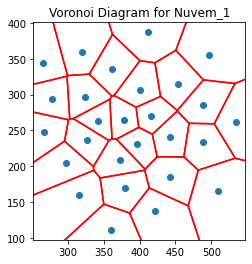

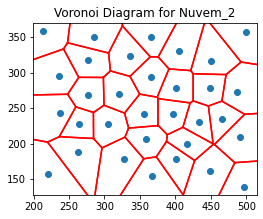

In [8]:
data1 = voronoi(np.loadtxt("nuvem1.txt"), "Nuvem_1")
data2 = voronoi(np.loadtxt("nuvem2.txt")[0:32], "Nuvem_2")
data1.plot_voronoi()
data2.plot_voronoi()
edges1 = data1.export_edges()
edges2 = data2.export_edges()

with open('arestas_1.txt', 'w') as f:
    for edge in edges1:
        for i, point in enumerate(edge):
            for j, value in enumerate(point):
                f.write(str(value))
                if i != 1 or j != 2:
                    f.write(",")
        f.write("\n")

with open('arestas_2.txt', 'w') as f:
    for edge in edges2:
        for i, point in enumerate(edge):
            for j, value in enumerate(point):
                f.write(str(value))
                if i != 1 or j != 2:
                    f.write(",")
        f.write("\n")

In [ ]:
sizes = [3, 4, 5, 6, 7, 8, 9, 10, 20]
run_time = []

for N in sizes:
    points = voronoi(np.random.rand(N, 2)*1000)
    start = time.time()
    points.make_voronoi()
    end = time.time()
    run_time.append(end-start)
             
plt.plot(sizes, run_time, "r")
plt.plot(sizes, [size**2/20000 for size in sizes], "b")
plt.xlabel('Input size')
plt.ylabel('time (s)')
plt.legend(["Voronoi","n**2"])
plt.grid(True)
plt.show()

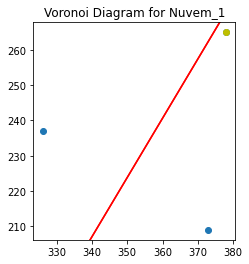

In [72]:
data1 = voronoi(np.loadtxt("nuvem1.txt")[0:3], "Nuvem_1")
data1.plot_voronoi()